In [1]:
# Ansh Bhargava & Vamshi Vallala
# Deep Learning Project Stage 3

# Imports

In [2]:
# base imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from collections import defaultdict

from glob import glob
import random
import math

In [3]:
# more imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

import tarfile
from scipy import stats
from sklearn.metrics import mean_squared_error
from functools import partial
from tensorflow.math import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score

# tf imports
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, AlphaDropout, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.initializers import he_normal, lecun_normal
from tensorflow.keras.optimizers import SGD, Adam, Adamax, Nadam, RMSprop
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# Authenticate and Access Data from Google Drive and Google Cloud Storage

In [4]:
# @title Access Google Drive
# Mount to access via file system

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# @title Access GCS (sharded TFrecord files)
# PyDrive to access Google Drive and Cloud Storage programmatically

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Check File Structure

In [6]:
# @title Sanity check that the file structure and instance counts are correct.
data_path_stage1 = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/orig_data/data_1"
data_path_stage345 = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/orig_data/data_345"



print("File Structure for stage 1 data: ")
print("data_path:", os.listdir(data_path_stage1))
print("\t", "data_path/train:", os.listdir(data_path_stage1 + "/train"))
print("\t", "data_path/val:", os.listdir(data_path_stage1 + "/val"))
print("\t", "data_path/test:", os.listdir(data_path_stage1 + "/test"))


print("\nFile Structure for stage 345 data: ")
print("data_path:", os.listdir(data_path_stage345))
print("\t", "data_path/train:", os.listdir(data_path_stage345 + "/train"))
print("\t", "data_path/val:", os.listdir(data_path_stage345 + "/val"))
print("\t", "data_path/test:", os.listdir(data_path_stage345 + "/test"))

File Structure for stage 1 data: 
data_path: ['val', 'test', 'train']
	 data_path/train: ['dog', 'tiger', 'house', 'bell', 'horse']
	 data_path/val: ['dog', 'tiger', 'house', 'bell', 'horse']
	 data_path/test: ['dog', 'tiger', 'house', 'bell', 'horse']

File Structure for stage 345 data: 
data_path: ['val', 'train', 'test']
	 data_path/train: ['bell', 'dog', 'horse', 'house', 'tiger']
	 data_path/val: ['bell', 'dog', 'horse', 'house', 'tiger']
	 data_path/test: ['bell', 'dog', 'horse', 'house', 'tiger']


In [7]:
# @title Set (local) paths
train_path_stage1 = data_path_stage1+'/train'
val_path_stage1 = data_path_stage1+'/val'
test_path_stage1 = data_path_stage1+'/test'

train_path_stage345 = data_path_stage345+'/train'
val_path_stage345 = data_path_stage345+'/val'
test_path_stage345 = data_path_stage345+'/test'

In [8]:
# @title Sanity check instance counts in local path with original data (stage 345)
classes = os.listdir(train_path_stage345)

num_train_images = 0
for class_name in classes:
    class_path = os.path.join(train_path_stage345, class_name)
    num_images = len(os.listdir(class_path))
    num_train_images += num_images
print('Number of train images:', num_train_images)


num_val_images = 0
for class_name in classes:
    class_path = os.path.join(val_path_stage345, class_name)
    num_images = len(os.listdir(class_path))
    num_val_images += num_images
print('Number of validation images:', num_val_images)


num_test_images = 0
for class_name in classes:
    class_path = os.path.join(test_path_stage345, class_name)
    num_images = len(os.listdir(class_path))
    num_test_images += num_images
print('Number of test images:', num_test_images)

Number of train images: 18000
Number of validation images: 2250
Number of test images: 2250


In [9]:
# @title Set paths to TFrecord data
local_tfr_path_stage1 = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/"
local_tfr_path_stage345 = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/"

gcs_path_stage1 = "gs://dl_image_classification/stage1/"
gcs_path_stage345 = "gs://dl_image_classification/stage345/"

# (One-time) Write images as TFRecords

In [ ]:
# @title Functions to serialize instances and write tfrecords to storage
def serialize_example(image, label):
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def make_tfrecords(path, record_file, num_shards):
    classes = os.listdir(path)
    os.makedirs(os.path.dirname(record_file), exist_ok=True)

    total_images_count = 0
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        num_images = len(os.listdir(class_path))
        total_images_count += num_images

    shard_size = total_images_count // num_shards
    shards_created = 0

    name = os.path.basename(record_file[:-1])
    
    files_list = []
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        files = glob(os.path.join(class_path, '*.png'))
        files_list += [(class_name, file) for file in files]

    random.shuffle(files_list)
    
    initial_shard_path = f"{record_file}{name}-000.tfrecord"
    writer = tf.io.TFRecordWriter(initial_shard_path)
    count = 0
    total_written = 0
    for class_name, filename in files_list:
        image_string = open(filename, 'rb').read()
        label = classes.index(class_name)
        tf_example = serialize_example(image_string, label)
        writer.write(tf_example)
        count += 1
        total_written += 1
        if count == shard_size:
            writer.close()
            print(f"Wrote {count} images to {record_file}{name}-{shards_created:03d}.tfrecord")
            shards_created += 1
            if shards_created != num_shards:
              writer = tf.io.TFRecordWriter(f"{record_file}{name}-{shards_created:03d}.tfrecord")
              count = 0

    print(f"Processed {total_written} images and wrote them to {shards_created} TFRecord files.")


def make_tfrecords_noshards(path, record_file):
    classes = os.listdir(path)
    os.makedirs(os.path.dirname(record_file), exist_ok=True)
    
    files_list = []
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        files = glob(os.path.join(class_path, '*.png'))
        files_list += [(class_name, file) for file in files]

    random.shuffle(files_list)
    total_written = 0

    with tf.io.TFRecordWriter(record_file) as writer:
      for class_name, filename in files_list:
          image_string = open(filename, 'rb').read()
          label = classes.index(class_name)
          tf_example = serialize_example(image_string, label)
          writer.write(tf_example)
          total_written += 1
          if total_written % 225 == 0:
            print(f"Wrote {total_written} images to {record_file}")

    print(f"Processed {total_written} images and wrote it to {record_file}.")

## Write to local (aka. drive) Storage (full .tfrecords)

In [ ]:
local_tfr_path_stage1 = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/"
local_tfr_path_stage345 = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/"

### Stage 1 data

In [ ]:
%%time
# Make TFRecords for train set (stage 1)
make_tfrecords_noshards(train_path_stage1, local_tfr_path_stage1+'train.tfrecords')

In [ ]:
%%time
# Make TFRecords for validation set (stage 1)
make_tfrecords_noshards(val_path_stage1, local_tfr_path_stage1+'val.tfrecords')

Wrote 225 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/val.tfrecords
Wrote 450 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/val.tfrecords
Wrote 675 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/val.tfrecords
Wrote 900 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/val.tfrecords
Wrote 1125 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/val.tfrecords
Wrote 1350 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/val.tfrecords
Wrote 1575 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/val.tfrecords
Wrote 1800 images to /content/drive/Othercomputers/MacBook 

In [ ]:
%%time
# Make TFRecords for test set (stage 1)
make_tfrecords_noshards(test_path_stage1, local_tfr_path_stage1+'test.tfrecords')

Wrote 225 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/test.tfrecords
Wrote 450 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/test.tfrecords
Wrote 675 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/test.tfrecords
Wrote 900 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/test.tfrecords
Wrote 1125 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/test.tfrecords
Wrote 1350 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/test.tfrecords
Wrote 1575 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage1/test.tfrecords
Wrote 1800 images to /content/drive/Othercomputers/M

### Stage 345 data (done)

In [ ]:
%%time
# Make TFRecords for train set (stage 345)
make_tfrecords_noshards(train_path_stage345, local_tfr_path_stage345+'train.tfrecords')

Wrote 225 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/train.tfrecords
Wrote 450 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/train.tfrecords
Wrote 675 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/train.tfrecords
Wrote 900 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/train.tfrecords
Wrote 1125 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/train.tfrecords
Wrote 1350 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/train.tfrecords
Wrote 1575 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/train.tfrecords
Wrote 1800 images to /content/d

In [ ]:
%%time
# Make TFRecords for validation set (stage 345)
make_tfrecords_noshards(val_path_stage345, local_tfr_path_stage345+'val.tfrecords')

Wrote 225 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/val.tfrecords
Wrote 450 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/val.tfrecords
Wrote 675 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/val.tfrecords
Wrote 900 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/val.tfrecords
Wrote 1125 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/val.tfrecords
Wrote 1350 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/val.tfrecords
Wrote 1575 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/val.tfrecords
Wrote 1800 images to /content/drive/Othercomp

In [ ]:
%%time
# Make TFRecords for test set (stage 345)
make_tfrecords_noshards(test_path_stage345, local_tfr_path_stage345+'test.tfrecords')

Wrote 225 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/test.tfrecords
Wrote 450 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/test.tfrecords
Wrote 675 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/test.tfrecords
Wrote 900 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/test.tfrecords
Wrote 1125 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/test.tfrecords
Wrote 1350 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/test.tfrecords
Wrote 1575 images to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345/test.tfrecords
Wrote 1800 images to /content/drive/Ot

## Write to GCS Bucket Storage (sharded .tfrecords)

In [ ]:
gcs_path_stage1 = "gs://dl_image_classification/stage1/"
gcs_path_stage345 = "gs://dl_image_classification/stage345/"

### Stage 1 data

In [ ]:
%%time
# Make TFRecords for train set (stage 1)
make_tfrecords(train_path_stage1, gcs_path_stage1+'train_shards/', 72)

In [ ]:
%%time
# Make TFRecords for validation set (stage 1)
make_tfrecords(val_path_stage1, gcs_path_stage1+'val_shards/', 10)

Wrote 225 images to gs://dl_image_classification/stage1/val_shards/val_shards-000.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/val_shards/val_shards-001.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/val_shards/val_shards-002.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/val_shards/val_shards-003.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/val_shards/val_shards-004.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/val_shards/val_shards-005.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/val_shards/val_shards-006.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/val_shards/val_shards-007.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/val_shards/val_shards-008.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/val_shards/val_shards-009.tfrecord
Processed 2250 images and wrote them to 10 TFRecord files.
CPU times: user 2.8 s, sys: 4.1

In [ ]:
%%time
# Make TFRecords for test set (stage 1)
make_tfrecords(test_path_stage1, gcs_path_stage1+'test_shards/', 10)

Wrote 225 images to gs://dl_image_classification/stage1/test_shards/test_shards-000.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/test_shards/test_shards-001.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/test_shards/test_shards-002.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/test_shards/test_shards-003.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/test_shards/test_shards-004.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/test_shards/test_shards-005.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/test_shards/test_shards-006.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/test_shards/test_shards-007.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/test_shards/test_shards-008.tfrecord
Wrote 225 images to gs://dl_image_classification/stage1/test_shards/test_shards-009.tfrecord
Processed 2250 images and wrote them to 10 TFRecord files.
CPU times: 

### Stage 345 data (done)

In [ ]:
%%time
# Make TFRecords for train set (stage 345)
make_tfrecords(train_path_stage345, gcs_path_stage345+'train_shards/', 72)

Wrote 250 images to gs://dl_image_classification/stage345/train_shards/train_shards-000.tfrecord
Wrote 250 images to gs://dl_image_classification/stage345/train_shards/train_shards-001.tfrecord
Wrote 250 images to gs://dl_image_classification/stage345/train_shards/train_shards-002.tfrecord
Wrote 250 images to gs://dl_image_classification/stage345/train_shards/train_shards-003.tfrecord
Wrote 250 images to gs://dl_image_classification/stage345/train_shards/train_shards-004.tfrecord
Wrote 250 images to gs://dl_image_classification/stage345/train_shards/train_shards-005.tfrecord
Wrote 250 images to gs://dl_image_classification/stage345/train_shards/train_shards-006.tfrecord
Wrote 250 images to gs://dl_image_classification/stage345/train_shards/train_shards-007.tfrecord
Wrote 250 images to gs://dl_image_classification/stage345/train_shards/train_shards-008.tfrecord
Wrote 250 images to gs://dl_image_classification/stage345/train_shards/train_shards-009.tfrecord
Wrote 250 images to gs://dl_im

In [ ]:
%%time
# Make TFRecords for validation set (stage 345)
make_tfrecords(val_path_stage345, gcs_path_stage345+'val_shards/', 10)

Wrote 225 images to gs://dl_image_classification/stage345/val_shards/val_shards-000.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/val_shards/val_shards-001.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/val_shards/val_shards-002.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/val_shards/val_shards-003.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/val_shards/val_shards-004.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/val_shards/val_shards-005.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/val_shards/val_shards-006.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/val_shards/val_shards-007.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/val_shards/val_shards-008.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/val_shards/val_shards-009.tfrecord
Processed 2250 images and wrote them to 10 TFRecord files.
CPU times: 

In [ ]:
%%time
# Make TFRecords for test set (stage 345)
make_tfrecords(test_path_stage345, gcs_path_stage345+'test_shards/', 10)

Wrote 225 images to gs://dl_image_classification/stage345/test_shards/test_shards-000.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/test_shards/test_shards-001.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/test_shards/test_shards-002.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/test_shards/test_shards-003.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/test_shards/test_shards-004.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/test_shards/test_shards-005.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/test_shards/test_shards-006.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/test_shards/test_shards-007.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/test_shards/test_shards-008.tfrecord
Wrote 225 images to gs://dl_image_classification/stage345/test_shards/test_shards-009.tfrecord
Processed 2250 images and wrote them to 10 TFRecor

In [ ]:
# @title Sanity check: image counts in GCS
# def count_images(path):
#     num_images = 0
#     for file_path in tf.io.gfile.glob(path + '*.tfrecord'):
#         for record in tf.data.TFRecordDataset(file_path):
#             example = tf.train.Example()
#             example.ParseFromString(record.numpy())
#             num_images += 1
#     return num_images


# num_train_images = count_images(gcs_path_stage345+'train_shards/')
# print(f"There are {num_train_images} images in the train_shards directory.")

# Hardware setup

In [10]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
tpu = tf.distribute.cluster_resolver.TPUClusterResolver() if 'COLAB_TPU_ADDR' in os.environ else None
if tpu:
  print("TPU")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  REPLICAS = strategy.num_replicas_in_sync
  BATCH_SIZE = 32
  # BATCH_SIZE = 32 * REPLICAS # keeps breaking (eager execution limits?)
else:
  print("GPU")
  strategy = tf.distribute.get_strategy()
  REPLICAS = strategy.num_replicas_in_sync
  BATCH_SIZE = 32 # Works on Colab Pro GPU, with ~8 million params. Could do w/ boosted RAM....
  # BATCH_SIZE = 128 # For when I ball out

  # Enable mixed precision - ONLY for GPU use
  tf.keras.mixed_precision.set_global_policy('mixed_float16')


AUTO = tf.data.AUTOTUNE
NUM_PARALLEL_CALLS = 16 * REPLICAS if tpu else AUTO

print(f'AUTO: {AUTO}')
print(f'REPLICAS: {REPLICAS}')
print(f'BATCH_SIZE: {BATCH_SIZE}')
print(f'NUM_PARALLEL_CALLS: {NUM_PARALLEL_CALLS}')

GPU
AUTO: -1
REPLICAS: 1
BATCH_SIZE: 32
NUM_PARALLEL_CALLS: -1


# Read images from (GCS) TFRecords files into datasets

In [11]:
# @title Functions to parse instances and read tfrecords
label_map = {
    "bell": 0,
    "dog": 1,
    "horse": 2,
    "house": 3,
    "tiger": 4
}

def _parse_image_function(example):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
  
    features = tf.io.parse_single_example(example, image_feature_description)
    image = tf.image.decode_png(features['image'], channels=3)
    image = tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(features['label'], tf.int32)

    # One-hot, in alphabetical order to match ImageGenerator
    label = features['label']  
    label = tf.one_hot(label, depth=len(label_map))

    return image, label



def read_dataset(filename, batch_size, augment=True, cache=False):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  filenames = tf.io.gfile.glob(filename + "*.tfrecord")
  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(_parse_image_function, num_parallel_calls=NUM_PARALLEL_CALLS)
  dataset = dataset.shuffle(3 * BATCH_SIZE)
  if augment:
      dataset = dataset.map(data_augment, num_parallel_calls=NUM_PARALLEL_CALLS)
  if cache:
      dataset = dataset.cache()

  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

# Data Augmentation

## Helper functions

In [12]:
'''
Randomly rotates an image by a given number of degrees, and returns the rotated image.
Does this by generating a rotation matrix, applying it to a list of destination pixel coordinates, 
and then finding the origin pixel values at the resulting rotated pixel coordinates.
'''
def transform_rotation(image, height, rotation):
    # For parity purposes, to ensure transformation is valid
    x_dimension = height % 2

    # Randomly rotate image by rotation degrees
    rotation = rotation * tf.random.uniform([1], dtype='float32')
    
    # Convert degrees to radians
    rotation = math.pi * rotation / 180.
    
    # Calculate rotation matrix
    cos_theta = tf.math.cos(rotation)
    sin_theta = tf.math.sin(rotation)
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([cos_theta, sin_theta, zero, -sin_theta, cos_theta, zero, zero, zero, one], axis=0), [3,3])

    # Generate list of destination pixel coordinates
    x_coords = tf.repeat(tf.range(height // 2, -height // 2, -1), height)
    y_coords = tf.tile(tf.range(-height // 2, height // 2), [height])
    z_coords = tf.ones([height * height], dtype='int32')
    dest_pixel_coords = tf.stack([x_coords, y_coords, z_coords])

    # Rotate destination pixels onto origin pixels
    rotated_pixel_coords = tf.matmul(rotation_matrix, tf.cast(dest_pixel_coords, dtype='float32'))
    rotated_pixel_coords = tf.cast(rotated_pixel_coords, dtype='int32')
    rotated_pixel_coords = tf.clip_by_value(rotated_pixel_coords, -height // 2 + x_dimension + 1, height // 2)

    # Find origin pixel values 
    origin_pixel_coords = tf.stack([height // 2 - rotated_pixel_coords[0, :], height // 2 - 1 + rotated_pixel_coords[1, :]])
    pixel_values = tf.gather_nd(image, tf.transpose(origin_pixel_coords))
        
    return tf.reshape(pixel_values, [height, height, 3])



'''
Randomly applies a shear transformation to an image, and returns the transformed image.
Does this by generating a shear matrix, applying it to a list of destination pixel coordinates, 
and then finding the origin pixel values at the resulting transformed pixel coordinates.
'''
def transform_shear(image, height, shear):
    # For parity purposes, to ensure transformation is valid
    x_dimension = height % 2
    
    # Convert shear from degrees to radians
    shear = shear * tf.random.uniform([1], dtype='float32')
    shear = math.pi * shear / 180.
        
    # Compute shear matrix
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one, s2, zero, zero, c2, zero, zero, zero, one], axis=0), [3, 3])    

    # List destination pixel indices
    x = tf.repeat(tf.range(height // 2, -height // 2, -1), height)
    y = tf.tile(tf.range(-height // 2, height // 2), [height])
    z = tf.ones([height * height], dtype='int32')
    destination_indices = tf.stack([x, y, z])

    # Rotate destination pixels onto origin pixels
    transformed_indices = tf.cast(K.dot(shear_matrix, tf.cast(destination_indices, dtype='float32')), dtype='int32')
    transformed_indices = K.clip(transformed_indices, -height // 2 + x_dimension + 1, height // 2)

    # Find origin pixel values
    origin_indices = tf.stack([height // 2 - transformed_indices[0, :], height // 2 - 1 + transformed_indices[1, :]])
    transformed_image = tf.gather_nd(image, tf.transpose(origin_indices))
        
    return tf.reshape(transformed_image, [height, height, 3])



'''
Shifts an image horizontally and vertically by a given number of pixels, and returns the shifted image.
Does this by generating a shift matrix, applying it to a list of destination pixel coordinates,
and then finding the origin pixel values at the resulting shifted pixel coordinates.
'''
def transform_shift(image, height, h_shift, w_shift):
    # For parity purposes, to ensure transformation is valid
    x_dimension = height % 2
    
    # Compute random shift amounts
    height_shift = h_shift * tf.random.uniform([1], dtype='float32') 
    width_shift = w_shift * tf.random.uniform([1], dtype='float32') 
    
    # Define identity and zero matrices
    identity_matrix = tf.constant([1], dtype='float32')
    zero_matrix = tf.constant([0], dtype='float32')
        
    # Define shift matrix
    shift_matrix = tf.reshape(tf.concat([identity_matrix, zero_matrix, height_shift, 
                                          zero_matrix, identity_matrix, width_shift, 
                                          zero_matrix, zero_matrix, identity_matrix], axis=0), [3, 3])

    # List destination pixel indices
    x_indices = tf.repeat(tf.range(height // 2, -height // 2, -1), height)
    y_indices = tf.tile(tf.range(-height // 2, height // 2), [height])
    ones = tf.ones([height * height], dtype='int32')
    pixel_indices = tf.stack([x_indices, y_indices, ones])

    # Rotate destination pixels onto origin pixels
    rotated_indices = K.dot(shift_matrix, tf.cast(pixel_indices, dtype='float32'))
    rotated_indices = K.cast(rotated_indices, dtype='int32')
    rotated_indices = K.clip(rotated_indices, -height // 2 + x_dimension + 1, height // 2)
    
    # Find origin pixel values
    origin_indices = tf.stack([height // 2 - rotated_indices[0, ], height // 2 - 1 + rotated_indices[1, ]])
    pixel_values = tf.gather_nd(image, tf.transpose(origin_indices))
        
    return tf.reshape(pixel_values, [height, height, 3])


'''
Randomly applies cutout to an image by masking out a rectangular area.
Does this by generating a binary mask tensor of zeros with the same shape as the image,
randomly determines the size and position of the rectangular area to mask out,
and then applies the mask to the image by element-wise multiplication.
'''
def random_cutout(image, height, width, min_mask_size, max_mask_size, num_masks):
  for i in range(num_masks):
      # Randomly generate the height and width of the mask.
      mask_height = tf.random.uniform([], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      mask_width = tf.random.uniform([], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)
      
      # Compute the amount of padding needed to fit the mask in the image.
      pad_h = tf.maximum(height - mask_height, 0)
      pad_w = tf.maximum(width - mask_width, 0)
      
      # Randomly determine the offset of the mask within the padded area.
      offset_h = tf.random.uniform([], maxval=pad_h, dtype=tf.int32)
      offset_w = tf.random.uniform([], maxval=pad_w, dtype=tf.int32)
      
      # Create a binary mask tensor of zeros with the shape of the image, and set the
      # appropriate region to ones to mask out that region.
      mask = tf.pad(tf.zeros([mask_height, mask_width, 3], dtype=tf.float32),
                    [[offset_h, pad_h - offset_h], [offset_w, pad_w - offset_w], [0, 0]],
                    constant_values=1)
      
      # Apply the mask to the image.
      image = image * mask

  return image

## Driver functions

In [13]:
config = {
  "HEIGHT": 512,
  "WIDTH": 512,
  "CHANNELS": 3
}


def data_augment(image, label):
    # Randomly apply shear transformation
    p_shear = np.random.uniform()
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, config['HEIGHT'], shear=20.)
        else:
            image = transform_shear(image, config['HEIGHT'], shear=-20.)
    
    # Randomly apply rotation transformation
    p_rotation = np.random.uniform()
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)
    
    # Randomly apply rotation transformation
    p_crop = np.random.uniform()
    if p_crop > .2:
        image = data_augment_crop(image)
    
    # Randomly apply 90deg rotation transformation
    p_rotate = np.random.uniform()
    if p_rotate > .2:
        image = data_augment_rotate(image)
    
    
    image = data_augment_flip_transpose(image) # Flip, then randomly transpose
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    # Randomly apply cutout transformation
    p_cutout = np.random.uniform()
    if p_cutout > .5:
        image = data_augment_cutout(image)
    
    return image, label


def data_augment_crop(image):
    p_crop = np.random.uniform()
    crop_size = np.random.randint(low=int(config['HEIGHT']*.7), high=config['HEIGHT'], dtype=np.int32)

    '''
    Randomly crops or central crops the image based on p_crop value.
    If p_crop > 0.5, a random crop of size [crop_size, crop_size, config['CHANNELS']] is taken.
    If p_crop is between 0.4 and 0.5, a central crop of 70% of the image size is taken.
    If p_crop is between 0.2 and 0.4, a central crop of 80% of the image size is taken.
    If p_crop is less than 0.2, a central crop of 90% of the image size is taken.
    '''
    if p_crop > 0.5:
      image = tf.image.random_crop(image, size=[crop_size, crop_size, config['CHANNELS']])
    elif p_crop > 0.2:
      image = tf.image.central_crop(image, central_fraction=1 - 0.1 * (p_crop // 0.1))
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_rotate(image):
    p_rotate = np.random.uniform()
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_flip_transpose(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    p_spatial = np.random.uniform()
    if p_spatial > 0.75: image = tf.image.transpose(image)

    return image


def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .1), int(config['HEIGHT'] * .1)), 
                        max_mask_size=(int(config['HEIGHT'] * .125), int(config['HEIGHT'] * .125))):
    
    p_cutout = np.random.uniform()
  
    # Determine number of cutouts
    if p_cutout > 0.85: n_cutout = np.random.randint(10, 16)
    elif p_cutout > 0.6: n_cutout = np.random.randint(5, 11)
    elif p_cutout > 0.25: n_cutout = np.random.randint(2, 6)
    else: n_cutout = 1

    # Apply random cutout
    image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                          min_mask_size=min_mask_size, max_mask_size=max_mask_size, num_masks=n_cutout)

    return image

# Speed Test Read (Local/full vs GCS/sharded)

We read from GCS storage because reading from local storage doesn't work well with a TPU. Google's home, Google's rules.

In [ ]:
# %%time
# train_dataset_full_local = read_dataset(local_tfr_path_stage345+'train.tfrecords', BATCH_SIZE, augment=True, cache=False)
# for _ in range(10):
#   speed = next(iter(train_dataset_full_local))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [ ]:
# %%time
# train_dataset_sharded_gcs = read_dataset(gcs_path_stage345+'train_shards/', BATCH_SIZE, augment=True, cache=False)
# for _ in range(10):
#   speed = next(iter(train_dataset_sharded_gcs))

CPU times: user 42.4 s, sys: 8.32 s, total: 50.7 s
Wall time: 1min 6s


# Sanity check Augmentation

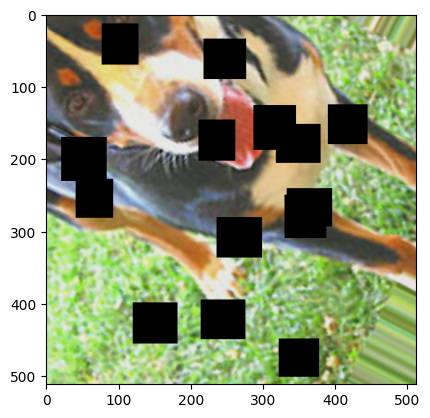

In [63]:
# Retrieve the first batch of data from the train dataset
train_dataset = read_dataset(gcs_path_stage345+'train_shards/', BATCH_SIZE, augment=True, cache=False)

train_data = next(iter(train_dataset))
image, label = train_data

# Display the first image of the first batch
image = image[0] * 255
image = np.squeeze(image.numpy().astype(np.uint8))

plt.imshow(image)
plt.show()

# Models

In [ ]:
# @title Lab 7 Model (deeper --> 1 million)

def lab_7_model():
    model = Sequential()

    DefaultConv2D = partial(tf.keras.layers.Conv2D, filters = 64, kernel_size=3, padding="same",
                        activation="selu", kernel_initializer="lecun_normal")
    
    # convolutions and pooling
    model.add(DefaultConv2D(input_shape=[512,512,3]))
    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(MaxPool2D(2))

    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(MaxPool2D(2))

    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(MaxPool2D(2))

    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(MaxPool2D(2))

    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(MaxPool2D(2))

    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(MaxPool2D(2))

    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(MaxPool2D(2))

    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(MaxPool2D(2))

    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(DefaultConv2D())
    model.add(MaxPool2D(2))

    # dense layers
    model.add(Flatten()) # flatten the image
    model.add(BatchNormalization())
    model.add(Dense(64, activation="selu"))
    model.add(AlphaDropout(rate = 0.1))
    model.add(Dense(64, activation="selu"))
    model.add(AlphaDropout(rate = 0.1))

    # output layer
    model.add(Dense(5, activation="softmax"))

    optimizer = Nadam()

    model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['categorical_accuracy'])
    return model


lab_7_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 512, 512, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 64)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      36928     
                                                        

In [ ]:
# @title Stage 3 Model (2 million)
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model

# Conv-BatchNorm block
def conv_bn(x, filters, kernel_size, strides=1):
  x = Conv2D(filters=filters, 
              kernel_size=kernel_size, 
              strides=strides, 
              padding='same', 
              use_bias=False)(x)
  x = BatchNormalization()(x)
  return x

# DepthwiseSeparableConv-BatchNorm block
def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters, 
                        kernel_size=kernel_size, 
                        strides=strides, 
                        padding='same', 
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

# First section
def first_section_2(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters=64, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=64, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=64, kernel_size=1, strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x

# Second section
def second_section_2(tensor):
    for _ in range(6):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=256, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters=256, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters=256, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
    return tensor

# Output section
def output_section_2(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=256,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=256,  kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense(units=5, activation='softmax')(x)
    
    return x

# Driver code
def Stage3_2mil():
    input = Input(shape = (512,512,3))
    x = first_section_2(input)
    x = second_section_2(x)
    output = output_section_2(x)

    model = Model(inputs=input, outputs=output)

    optimizer = Adam(learning_rate = 0.0001)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'])
    
    return model

Stage3_2mil().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 32  128        ['conv2d_27[0][0]']              
 rmalization)                   )                                                             

In [ ]:
# @title Stage 3 Model (4 million)
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model

# Conv-BatchNorm block
def conv_bn(x, filters, kernel_size, strides=1):
  x = Conv2D(filters=filters, 
              kernel_size=kernel_size, 
              strides=strides, 
              padding='same', 
              use_bias=False)(x)
  x = BatchNormalization()(x)
  return x

# DepthwiseSeparableConv-BatchNorm block
def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters, 
                        kernel_size=kernel_size, 
                        strides=strides, 
                        padding='same', 
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

# First section
def first_section_4(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters=64, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=64, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=64, kernel_size=1, strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x

# Second section
def second_section_4(tensor):
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=256, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters=512, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters=256, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
    return tensor

# Output section
def output_section_4(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters=512, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense(units=5, activation='softmax')(x)
    
    return x

# Driver code
def Stage3_4mil():
    input = Input(shape = (512,512,3))
    x = first_section_4(input)
    x = second_section_4(x)
    output = output_section_4(x)

    model = Model(inputs=input, outputs=output)

    optimizer = Adam(learning_rate = 0.0001)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'])
    
    return model

Stage3_4mil().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 256, 256, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_35 (BatchN  (None, 256, 256, 32  128        ['conv2d_33[0][0]']              
 ormalization)                  )                                                           

In [25]:
# @title Stage 3 Model (8 million)
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model

# Conv-BatchNorm block
def conv_bn(x, filters, kernel_size, strides=1):
  x = Conv2D(filters=filters, 
              kernel_size=kernel_size, 
              strides=strides, 
              padding='same', 
              use_bias=False)(x)
  x = BatchNormalization()(x)
  return x

# DepthwiseSeparableConv-BatchNorm block
def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters, 
                        kernel_size=kernel_size, 
                        strides=strides, 
                        padding='same', 
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

# First section
def first_section_8(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters=64, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=64, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=64, kernel_size=1, strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters=512, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=512, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters=512, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x

# Second section
def second_section_8(tensor):
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=512, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters=512, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters=512, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
    return tensor

# Output section
def output_section_8(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters=512, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense(units=5, activation='softmax')(x)
    
    return x

# Driver code
def Stage3_8mil():
    input = Input(shape = (512,512,3))
    x = first_section_8(input)
    x = second_section_8(x)
    output = output_section_8(x)

    model = Model(inputs=input, outputs=output)

    optimizer = Adam(learning_rate = 0.0001)
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'])
    
    return model

Stage3_8mil().summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 256, 256, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_80 (BatchN  (None, 256, 256, 32  128        ['conv2d_12[0][0]']              
 ormalization)                  )                                                           

In [ ]:
# @title Stage 3 Model (16 million)
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model

# Conv-BatchNorm block
def conv_bn(x, filters, kernel_size, strides=1):
  x = Conv2D(filters=filters, 
              kernel_size=kernel_size, 
              strides=strides, 
              padding='same', 
              use_bias=False)(x)
  x = BatchNormalization()(x)
  return x

# DepthwiseSeparableConv-BatchNorm block
def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters, 
                        kernel_size=kernel_size, 
                        strides=strides, 
                        padding='same', 
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

# First section
def first_section_16(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters=64, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=64, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=64, kernel_size=1, strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters=512, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=512, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters=512, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x

# Second section
def second_section_16(tensor):
    for _ in range(16):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=512, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters=512, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters=512, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
    return tensor


# Output section
def output_section_16(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters=512, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters=1024,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=1024,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense(units=5, activation='softmax')(x)
    
    return x

# Driver code
def Stage3_16mil():
    input = Input(shape = (512,512,3))
    x = first_section_16(input)
    x = second_section_16(x)
    output = output_section_16(x)

    model = Model(inputs=input, outputs=output)

    optimizer = Adam(learning_rate = 0.0001)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'])
    
    return model

Stage3_16mil().summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 256, 256, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_115 (Batch  (None, 256, 256, 32  128        ['conv2d_45[0][0]']              
 Normalization)                 )                                                           

# Train

In [26]:
# @title Model training configs
local_info_path = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/"

train_dataset_345 = read_dataset(gcs_path_stage345+'train_shards/', BATCH_SIZE, augment=True, cache=False)
val_dataset_345 = read_dataset(gcs_path_stage345+'val_shards/', BATCH_SIZE, augment=False, cache=False)


train_dataset_1 = read_dataset(gcs_path_stage1+'train_shards/', BATCH_SIZE, augment=True, cache=False)
val_dataset_1 = read_dataset(gcs_path_stage1+'val_shards/', BATCH_SIZE, augment=False, cache=False)

In [27]:
# @title Model training driver function
def train_model(train_dataset=None, val_dataset=None,
                model_fn=None, model=None, model_name=None,
                epochs=None, prev_count = 0,
                es=False, lr_sched=False):
  
  with strategy.scope():
    if model is None:
      model = model_fn()
    if model_name is None:  
      model_name = model_fn.__name__


  # Callbacks
  early_stop = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.02,
                           verbose=1, patience=5, restore_best_weights=True)
  
  lr_scheduler = ReduceLROnPlateau(monitor = "val_loss", factor=0.5,
          patience=5, verbose=1)
  
  log_dir = local_info_path + "logs/" + model_name
  tb = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,
                            write_images=True)

  checkpoint_dir = local_info_path + "checkpoints/" + model_name
  checkpoints = tf.keras.callbacks.ModelCheckpoint(
                        filepath=checkpoint_dir + f"/{model_name}-{prev_count}-{{epoch:02d}}-{{val_loss:.2f}}.h5",
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False,
                        mode='min',
                        save_freq='epoch')

  callbacks = [tb, checkpoints]
  if es: callbacks.append(early_stop)
  if lr_sched: callbacks.append(lr_scheduler)

  model.fit(train_dataset, epochs=epochs,
            steps_per_epoch = num_train_images // BATCH_SIZE,
            validation_data = val_dataset,
            validation_steps = num_val_images // BATCH_SIZE,
            callbacks=callbacks)
    
  return model

### [Old] Train on Stage 1 data

In [ ]:
# @title [Stage 1 data] Training Stage3 (2mil params, 10 epochs)
Stage3_2mil_10epochs = train_model(train_dataset=train_dataset_1, val_dataset=val_dataset_1,
                                   model_fn=Stage3_2mil,
                                   epochs=10)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 1.2450 - sparse_categorical_accuracy: 0.4952
Epoch 1: val_loss improved from inf to 1.95568, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/data_tfr/checkpoints/Stage3_2mil/Stage3_2mil-01-1.96.h5
562/562 [==============================] - 407s 630ms/step - loss: 1.2450 - sparse_categorical_accuracy: 0.4952 - val_loss: 1.9557 - val_sparse_categorical_accuracy: 0.2067
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 1.0404 - sparse_categorical_accuracy: 0.5934
Epoch 2: val_loss improved from 1.95568 to 1.57787, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/data_tfr/checkpoints/Stage3_2mil/Stage3_2mil-02-1.58.h5
562/562 [==============================] - 346s 616ms/step - loss: 1.0404 - sparse_categorical_accuracy: 0.5934 - val_loss: 1.5779 - val_sparse_categorical_accuracy: 0.4433
Epoch 3/10
5

In [ ]:
# @title [Stage 1 data] Training Stage3 (4mil params, 10 epochs)
Stage3_4mil_10epochs = train_model(train_dataset=train_dataset_1, val_dataset=val_dataset_1,
                                   model_fn=Stage3_4mil,
                                   epochs=10)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 1.2318 - sparse_categorical_accuracy: 0.5024
Epoch 1: val_loss improved from inf to 1.79697, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/data_tfr/checkpoints/Stage3_4mil/Stage3_4mil-01-1.80.h5
562/562 [==============================] - 400s 656ms/step - loss: 1.2318 - sparse_categorical_accuracy: 0.5024 - val_loss: 1.7970 - val_sparse_categorical_accuracy: 0.2058
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.9610 - sparse_categorical_accuracy: 0.6374
Epoch 2: val_loss improved from 1.79697 to 1.67348, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/data_tfr/checkpoints/Stage3_4mil/Stage3_4mil-02-1.67.h5
562/562 [==============================] - 362s 645ms/step - loss: 0.9610 - sparse_categorical_accuracy: 0.6374 - val_loss: 1.6735 - val_sparse_categorical_accuracy: 0.4094
Epoch 3/10
5

In [ ]:
# @title [Stage 1 data] Training Stage3 (8mil params, 10 epochs)
Stage3_8mil_10epochs = train_model(train_dataset=train_dataset_1, val_dataset=val_dataset_1,
                                   model_fn=Stage3_8mil,
                                   epochs=10)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 1.2352 - sparse_categorical_accuracy: 0.5051
Epoch 1: val_loss improved from inf to 1.71085, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/data_tfr/checkpoints/Stage3_8mil/Stage3_8mil-01-1.71.h5
562/562 [==============================] - 418s 697ms/step - loss: 1.2352 - sparse_categorical_accuracy: 0.5051 - val_loss: 1.7109 - val_sparse_categorical_accuracy: 0.2112
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.9863 - sparse_categorical_accuracy: 0.6213
Epoch 2: val_loss improved from 1.71085 to 0.94128, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/data_tfr/checkpoints/Stage3_8mil/Stage3_8mil-02-0.94.h5
562/562 [==============================] - 396s 704ms/step - loss: 0.9863 - sparse_categorical_accuracy: 0.6213 - val_loss: 0.9413 - val_sparse_categorical_accuracy: 0.6348
Epoch 3/10
5

### [Old] Train w/ old augmentation function

In [ ]:
# @title Training Stage3 (2mil params, 10 epochs)
Stage3_2mil_10epochs = train_model(train_dataset=train_dataset_345, val_dataset=val_dataset_345,
                                   model_fn=Stage3_2mil,
                                   epochs=10)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 1.1866 - sparse_categorical_accuracy: 0.5256
Epoch 1: val_loss improved from inf to 1.75776, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_2mil/Stage3_2mil-01-1.76.h5
562/562 [==============================] - 361s 607ms/step - loss: 1.1866 - sparse_categorical_accuracy: 0.5256 - val_loss: 1.7578 - val_sparse_categorical_accuracy: 0.2143
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.8881 - sparse_categorical_accuracy: 0.6647
Epoch 2: val_loss improved from 1.75776 to 1.47497, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_2mil/Stage3_2mil-02-1.47.h5
562/562 [==============================] - 366s 652ms/step - loss: 0.8881 - sparse_categorical_accuracy: 0.6647 - val_loss: 1.4750 - val_sparse_categorical_accuracy: 0.4313
Epoch 

In [ ]:
# @title Training Stage3 (4mil params, 10 epochs)
Stage3_4mil_10epochs = train_model(train_dataset=train_dataset_345, val_dataset=val_dataset_345,
                                   model_fn=Stage3_4mil,
                                   epochs=10)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 1.1590 - sparse_categorical_accuracy: 0.5367
Epoch 1: val_loss improved from inf to 1.81438, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_4mil/Stage3_4mil-01-1.81.h5
562/562 [==============================] - 409s 669ms/step - loss: 1.1590 - sparse_categorical_accuracy: 0.5367 - val_loss: 1.8144 - val_sparse_categorical_accuracy: 0.2326
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.8707 - sparse_categorical_accuracy: 0.6694
Epoch 2: val_loss improved from 1.81438 to 1.62266, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_4mil/Stage3_4mil-02-1.62.h5
562/562 [==============================] - 351s 624ms/step - loss: 0.8707 - sparse_categorical_accuracy: 0.6694 - val_loss: 1.6227 - val_sparse_categorical_accuracy: 0.4246
Epoch 

In [ ]:
# @title Training Stage3 (8mil params, 10 epochs)
Stage3_8mil_10epochs = train_model(train_dataset=train_dataset_345, val_dataset=val_dataset_345,
                                   model_fn=Stage3_8mil,
                                   epochs=10)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 1.1649 - sparse_categorical_accuracy: 0.5378
Epoch 1: val_loss improved from inf to 1.76417, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_8mil/Stage3_8mil-01-1.76.h5
562/562 [==============================] - 396s 665ms/step - loss: 1.1649 - sparse_categorical_accuracy: 0.5378 - val_loss: 1.7642 - val_sparse_categorical_accuracy: 0.2000
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.8565 - sparse_categorical_accuracy: 0.6779
Epoch 2: val_loss did not improve from 1.76417
562/562 [==============================] - 372s 662ms/step - loss: 0.8565 - sparse_categorical_accuracy: 0.6779 - val_loss: 2.3813 - val_sparse_categorical_accuracy: 0.3362
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 0.7462 - sparse_categorical_accuracy: 0.7227
Epoch 3: val_loss did not improve from 1.76417
562/562 

8 million seems to be approximately equally time efficient to train given equal batch size (32).

In [ ]:
# @title Training Stage3 (8mil params, 10-60 epochs)
Stage3_8mil_10to60epochs = train_model(train_dataset=train_dataset_345, val_dataset=val_dataset_345,
                                        model = Stage3_8mil_10epochs,
                                        model_name="Stage3_8mil_10-60epochs",
                                        epochs=50)

Epoch 1/50
562/562 [==============================] - ETA: 0s - loss: 0.4444 - sparse_categorical_accuracy: 0.8376
Epoch 1: val_loss improved from inf to 1.86010, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_8mil_10-60epochs/Stage3_8mil_10-60epochs-01-1.86.h5
562/562 [==============================] - 389s 685ms/step - loss: 0.4444 - sparse_categorical_accuracy: 0.8376 - val_loss: 1.8601 - val_sparse_categorical_accuracy: 0.4634
Epoch 2/50
562/562 [==============================] - ETA: 0s - loss: 0.4341 - sparse_categorical_accuracy: 0.8395
Epoch 2: val_loss improved from 1.86010 to 1.63896, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_8mil_10-60epochs/Stage3_8mil_10-60epochs-02-1.64.h5
562/562 [==============================] - 374s 665ms/step - loss: 0.4341 - sparse_categorical_accuracy: 0.8395 - val_loss: 1.6390 

### Final Model Training

In [28]:
# @title Training Stage3 Model: 8mil params, 0-20 epochs
Stage3_8mil = train_model(train_dataset=train_dataset_345,
                          val_dataset=val_dataset_345,
                          model_fn=Stage3_8mil,
                          model_name="Stage3_8mil",
                          epochs=20)

Epoch 1/20
562/562 [==============================] - ETA: 0s - loss: 1.2876 - categorical_accuracy: 0.4742
Epoch 1: val_loss improved from inf to 1.76501, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_8mil/Stage3_8mil-0-01-1.77.h5
562/562 [==============================] - 422s 711ms/step - loss: 1.2876 - categorical_accuracy: 0.4742 - val_loss: 1.7650 - val_categorical_accuracy: 0.2161
Epoch 2/20
562/562 [==============================] - ETA: 0s - loss: 1.0558 - categorical_accuracy: 0.5872
Epoch 2: val_loss improved from 1.76501 to 1.23785, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_8mil/Stage3_8mil-0-02-1.24.h5
562/562 [==============================] - 401s 715ms/step - loss: 1.0558 - categorical_accuracy: 0.5872 - val_loss: 1.2378 - val_categorical_accuracy: 0.5500
Epoch 3/20
562/562 [========================

In [29]:
# @title Training Stage3 Model: 8mil params, 20-30 epochs
Stage3_8mil = train_model(train_dataset=train_dataset_345,
                          val_dataset=val_dataset_345,
                          model=Stage3_8mil,
                          model_name="Stage3_8mil",
                          epochs=10, prev_count=20)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 0.4386 - categorical_accuracy: 0.8384
Epoch 1: val_loss improved from inf to 0.60412, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_8mil/Stage3_8mil-20-01-0.60.h5
562/562 [==============================] - 410s 725ms/step - loss: 0.4386 - categorical_accuracy: 0.8384 - val_loss: 0.6041 - val_categorical_accuracy: 0.7969
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.4310 - categorical_accuracy: 0.8412
Epoch 2: val_loss did not improve from 0.60412
562/562 [==============================] - 401s 715ms/step - loss: 0.4310 - categorical_accuracy: 0.8412 - val_loss: 0.6433 - val_categorical_accuracy: 0.7960
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 0.4171 - categorical_accuracy: 0.8450
Epoch 3: val_loss improved from 0.60412 to 0.55787, saving model to /content/drive/Othercomputers/Mac

In [30]:
# @title Training Stage3 Model: 8mil params, 30-50 epochs
Stage3_8mil = train_model(train_dataset=train_dataset_345, val_dataset=val_dataset_345,
                          model=Stage3_8mil,
                          model_name="Stage3_8mil",
                          epochs=20, prev_count=30)

Epoch 1/20
562/562 [==============================] - ETA: 0s - loss: 0.3452 - categorical_accuracy: 0.8712
Epoch 1: val_loss improved from inf to 0.46405, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_8mil/Stage3_8mil-30-01-0.46.h5
562/562 [==============================] - 419s 741ms/step - loss: 0.3452 - categorical_accuracy: 0.8712 - val_loss: 0.4640 - val_categorical_accuracy: 0.8460
Epoch 2/20
562/562 [==============================] - ETA: 0s - loss: 0.3468 - categorical_accuracy: 0.8716
Epoch 2: val_loss did not improve from 0.46405
562/562 [==============================] - 420s 748ms/step - loss: 0.3468 - categorical_accuracy: 0.8716 - val_loss: 0.4691 - val_categorical_accuracy: 0.8388
Epoch 3/20
562/562 [==============================] - ETA: 0s - loss: 0.3263 - categorical_accuracy: 0.8807
Epoch 3: val_loss did not improve from 0.46405
562/562 [==============================] - 418s 744ms/

In [31]:
# @title Training Stage3 Model: 8mil params, 50-70 epochs
Stage3_8mil = train_model(train_dataset=train_dataset_345, val_dataset=val_dataset_345,
                          model=Stage3_8mil,
                          model_name="Stage3_8mil",
                          epochs=20, prev_count=50,
                          lr_sched=True)

Epoch 1/20
562/562 [==============================] - ETA: 0s - loss: 0.2313 - categorical_accuracy: 0.9139
Epoch 1: val_loss improved from inf to 0.49004, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_8mil/Stage3_8mil-50-01-0.49.h5
562/562 [==============================] - 417s 737ms/step - loss: 0.2313 - categorical_accuracy: 0.9139 - val_loss: 0.4900 - val_categorical_accuracy: 0.8509 - lr: 1.0000e-04
Epoch 2/20
562/562 [==============================] - ETA: 0s - loss: 0.2336 - categorical_accuracy: 0.9149
Epoch 2: val_loss did not improve from 0.49004
562/562 [==============================] - 415s 739ms/step - loss: 0.2336 - categorical_accuracy: 0.9149 - val_loss: 0.6917 - val_categorical_accuracy: 0.8027 - lr: 1.0000e-04
Epoch 3/20
562/562 [==============================] - ETA: 0s - loss: 0.2251 - categorical_accuracy: 0.9168
Epoch 3: val_loss improved from 0.49004 to 0.41369, saving model to

In [32]:
# @title Training Stage3 Model: 8mil params, 70-100 epochs
Stage3_8mil = train_model(train_dataset=train_dataset_345, val_dataset=val_dataset_345,
                          model=Stage3_8mil,
                          model_name="Stage3_8mil",
                          epochs=30, prev_count=70,
                          lr_sched=True)

Epoch 1/30
562/562 [==============================] - ETA: 0s - loss: 0.1151 - categorical_accuracy: 0.9583
Epoch 1: val_loss improved from inf to 0.45435, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_8mil/Stage3_8mil-70-01-0.45.h5
562/562 [==============================] - 402s 710ms/step - loss: 0.1151 - categorical_accuracy: 0.9583 - val_loss: 0.4543 - val_categorical_accuracy: 0.8817 - lr: 5.0000e-05
Epoch 2/30
562/562 [==============================] - ETA: 0s - loss: 0.1098 - categorical_accuracy: 0.9604
Epoch 2: val_loss did not improve from 0.45435
562/562 [==============================] - 393s 700ms/step - loss: 0.1098 - categorical_accuracy: 0.9604 - val_loss: 0.4838 - val_categorical_accuracy: 0.8821 - lr: 5.0000e-05
Epoch 3/30
562/562 [==============================] - ETA: 0s - loss: 0.1057 - categorical_accuracy: 0.9630
Epoch 3: val_loss improved from 0.45435 to 0.38022, saving model to

FailedPreconditionError: ignored

# Evaluate

In [38]:
model_hidden = Stage3_8mil

In [39]:
# load best val
model_path = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage3_8mil/Stage3_8mil-70-08-0.34.h5"

model = tf.keras.models.load_model(model_path) 

In [40]:
# create the test dataset
test_dataset = read_dataset(gcs_path_stage345+'test_shards/', BATCH_SIZE, augment=False, cache=False)

# calculate the number of steps to evaluate
num_steps = num_test_images // BATCH_SIZE

# evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, steps=num_steps)

70/70 [==============================] - 49s 658ms/step - loss: 0.4234 - categorical_accuracy: 0.8862


In [41]:
%%capture
# predict the labels for the test dataset
y_pred = []
y_true = []
for i, (x, y) in enumerate(test_dataset.take(num_steps)):
    y_pred_batch = model.predict(x)
    y_pred += y_pred_batch.argmax(axis=-1).tolist()
    y_true += y.numpy().argmax(axis=-1).tolist()

In [42]:
# calculate the F1 score
f1 = f1_score(y_true, y_pred, average='macro')

# print the test metrics and F1 score
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('F1 score:', f1)

Test loss: 0.423432856798172
Test accuracy: 0.8861607313156128
F1 score: 0.8877024507450153


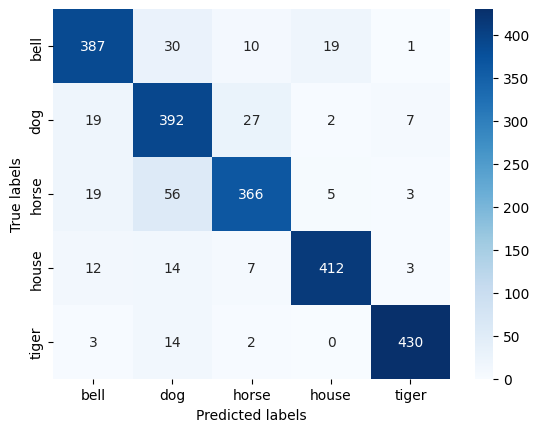

In [45]:
conf_matrix = confusion_matrix(y_true, y_pred)
ticklabels = ["bell", "dog", "horse", "house", "tiger"]
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=ticklabels, yticklabels=ticklabels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

1/1 [==============================] - 0s 92ms/step


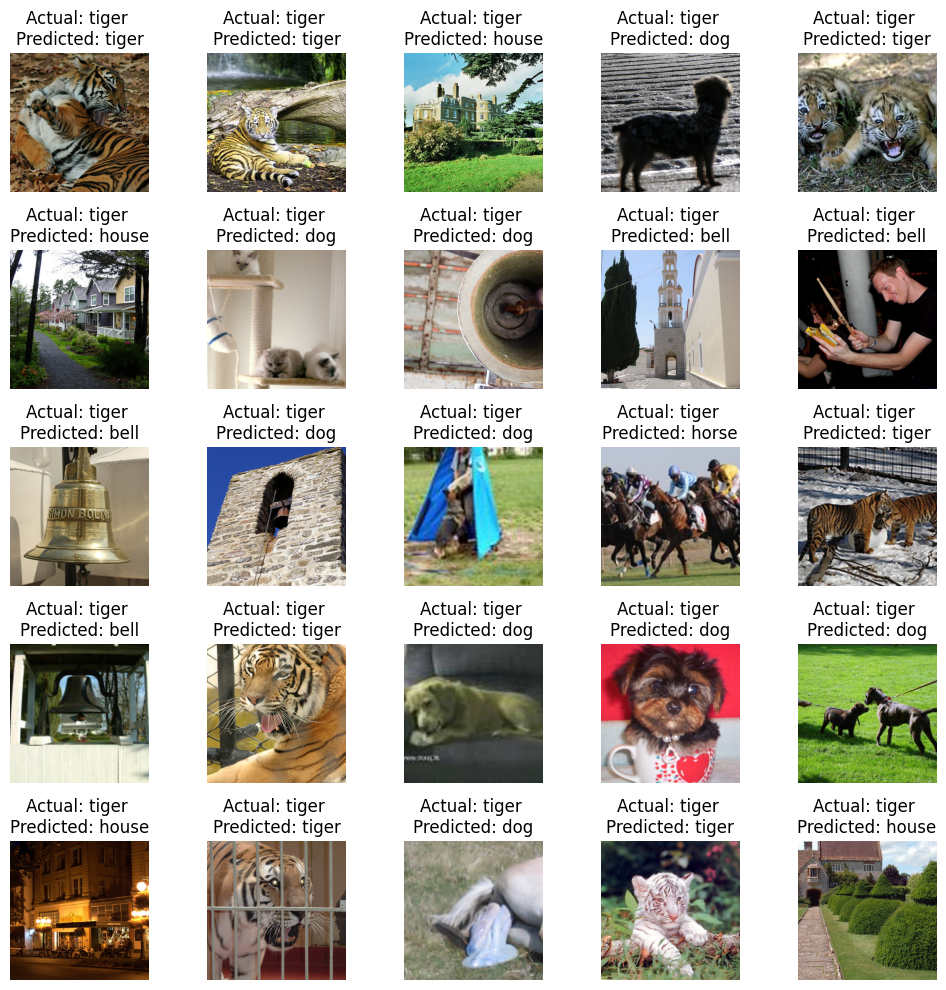

In [61]:
# @title Show 25 examples from test set
test_path = data_path_stage345+'/test'
class_names = os.listdir(test_path)

test_iterator = iter(test_dataset)
images, labels = next(test_iterator)
indices = np.random.choice(images.shape[0], size=25, replace=False)
sample_images = images.numpy()[indices]
sample_labels = labels.numpy()[indices]

predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=-1).tolist()


# display the images with their predicted and actual labels
plt.figure(figsize=(10, 10))
for i in range(sample_images.shape[0]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Actual: %s \nPredicted: %s" % (class_names[np.argmax(sample_labels[0])], class_names[predicted_labels[i]]))
    plt.axis("off")

plt.tight_layout()
plt.show()

# Save Model

In [ ]:
Stage3_8mil.save("Stage3_8mil", save_format="tf")

In [ ]:
from google.colab import files
!zip -r Stage3_8mil.zip "Stage3_8mil"/ 
files.download("Stage3_8mil.zip")

# Old Code

In [ ]:
# @title Writing TFrecords

# No shards

# def make_tfrecords_noshards(path, record_file):
#     classes = os.listdir(path)
#     os.makedirs(os.path.dirname(record_file), exist_ok=True)
#     with tf.io.TFRecordWriter(record_file) as writer:
#         for class_name in classes:
#             class_path = os.path.join(path, class_name)
#             files_list = glob(os.path.join(class_path, '*.png'))
#             random.shuffle(files_list)
#             for filename in files_list:
#                 image_string = open(filename, 'rb').read()
#                 label = classes.index(class_name)
#                 tf_example = serialize_example(image_string, label)
#                 writer.write(tf_example)


# def make_tfrecords(path, record_file, num_shards):
#     classes = os.listdir(path)
#     os.makedirs(os.path.dirname(record_file), exist_ok=True)
    
#     total_images_count = 0
#     for class_name in classes:
#       class_path = os.path.join(path, class_name)
#       num_images = len(os.listdir(class_path))
#       total_images_count += num_images

#     shard_size = total_images_count // num_shards
#     shards_created = 0

#     name = os.path.basename(record_file[:-1]) 
    
#     for shard_id in range(num_shards):
#       shard_path = f"{record_file}{name}-{shard_id:03d}.tfrecord"
#       with tf.io.TFRecordWriter(shard_path) as writer:
#           count = 0 # initialize the image counter for this shard
#           for class_name in classes:
#               print(class_name)
#               class_path = os.path.join(path, class_name)
#               files_list = glob(os.path.join(class_path, '*.png'))
#               random.shuffle(files_list)
#               for filename in files_list:
#                   image_string = open(filename, 'rb').read()
#                   label = classes.index(class_name)
#                   tf_example = serialize_example(image_string, label)
#                   writer.write(tf_example)
#                   count += 1
#                   if count == shard_size:
#                     break
#               if count == shard_size:
#                     break
#       shards_created += 1

#     assert(shards_created * shard_size == total_images_count)

In [ ]:
# @title Reading TFrecordS (no sharding)
# ORIGINAL - no sharding

# def read_dataset(filename, batch_size, strategy=None, augment=True, cache=False):
#     dataset = tf.data.TFRecordDataset(filename, num_parallel_reads=AUTO)
#     dataset = dataset.map(_parse_image_function, num_parallel_calls=NUM_PARALLEL_CALLS)
#     dataset = dataset.shuffle(3 * BATCH_SIZE)
#     dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    
#     if augment:
#         dataset = dataset.map(train_augment, num_parallel_calls=NUM_PARALLEL_CALLS)

#     dataset = dataset.repeat()

#     if cache:
#         dataset = dataset.cache()

#     dataset = dataset.prefetch(buffer_size=16 * BATCH_SIZE * REPLICAS)
#     # dataset = dataset.prefetch(BATCH_SIZE)
    
#     return dataset


# With shards

In [ ]:
# @title Data Augmentation
# OLD FUNC, using new_data_augment now

# def train_augment(image, label):
#     # Randomly flip the image left or right
#     image = tf.image.random_flip_left_right(image)

#     # Randomly adjust the brightness of the image
#     image = tf.image.random_brightness(image, max_delta=0.1)
    
#     # Randomly adjust the contrast of the image
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

#     # Randomly adjust the hue of the image
#     image = tf.image.random_hue(image, max_delta=0.1)

#     # Randomly adjust the saturation of the image
#     image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

#     return image, label